In [1]:
import os
import json
import numpy as np
import pandas as pd

# plotting modules
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 5, 'ytick.major.width': 1.5, 'ytick.major.size': 4})
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def save_pdf(save_file, fig):
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight')
    pdf.close()
    return

In [3]:
intersect_file = "/data5/deepro/ukbiobank/papers/bmi_project/4_characterization/obesity_related_diseases/data/upset_files/protection_intersects.json"
combo_file = "/data5/deepro/ukbiobank/papers/bmi_project/4_characterization/obesity_related_diseases/data/merged_combos/protective_combos.csv"
icd_names_file = "/data5/deepro/ukbiobank/papers/bmi_project/2_prepare_data_for_analysis/obesity_related_diseases/data/tables/obesity_related_diseases_icd.csv"

In [4]:
def read_intersects_file(json_file):
    with open(json_file, "r") as f:
        json_object = json.load(f)
    return json_object

def get_all_unique_genes_combos_from_intersect_dict(intersect_dict):
    unique_combos = set(sum(list(map(lambda x: x.split("||"), list(intersect_dict.values()))), []))
    unique_genes = set(sum(list(map(lambda x: x.split("_"), unique_combos)), []))
    return unique_genes, unique_combos

def get_icd_dict(icd_names_file):
    icd_names = pd.read_csv(icd_names_file)
    icd_names_dict = {c.replace(" ", ""): m for c,m in zip(icd_names.coding, icd_names.meaning)}
    return icd_names_dict

def prepare_icd_plot_data(combo_file, unique_combo, icd_names_file, max_combo=3):
    combo_df = pd.read_csv(combo_file)
    combo_df = combo_df.loc[combo_df.unique_combo_id.isin(unique_combo)].sort_values("unique_combo_id")
    icd_names_dict = get_icd_dict(icd_names_file)
    combo_df["Phenotype"] = combo_df.Phenotype.map(icd_names_dict)
    # assign combo numbers
    combo_df["combo_num"] = range(len(combo_df))
    # melt the combo df to get all items
    melted_combo_df = combo_df.melt(id_vars=["combo_num"], value_vars=[f"Item_{i}_symbol" for i in range(1, max_combo+1)] + ["Phenotype"]).drop(columns=["variable"])
    # one hot encode the melted combo df
    combo_plot_df = pd.get_dummies(melted_combo_df, columns=["value"], prefix="", prefix_sep="").groupby("combo_num").agg(sum)
    gene_cols = sorted(set([g for g in combo_df.loc[:, [f"Item_{i}_symbol" for i in range(1, 3+1)]].values.flatten() if not pd.isnull(g)]))
    icd_cols = sorted(set([i for i in combo_df.loc[:, ["Phenotype"]].values.flatten() if not pd.isnull(i)]))
    combo_sample_dict = dict(zip(combo_df.combo_num, combo_df.Case_Samples))
    combo_plot_df["samples"] = combo_plot_df.index.map(combo_sample_dict)
    return combo_plot_df.reset_index().set_index(["combo_num", "samples"]), gene_cols, icd_cols

In [5]:
# read the icd protection intersecting gene combo dict
intersect_dict = read_intersects_file(intersect_file)
# filter the intersect dict to keep only samples who are protected for 3 icd codes
intersect_dict = {k:v for k,v in intersect_dict.items() if len(k.split("||")[0].split(","))>2}
unique_genes, unique_combos = get_all_unique_genes_combos_from_intersect_dict(intersect_dict)
# make combo plot data
combo_plot_df, gene_cols, other_cols = prepare_icd_plot_data(combo_file, unique_combos, icd_names_file)
combo_plot_df["Obesity_risk"] = [len(c.split(",")) for c in combo_plot_df.index.get_level_values(1)]

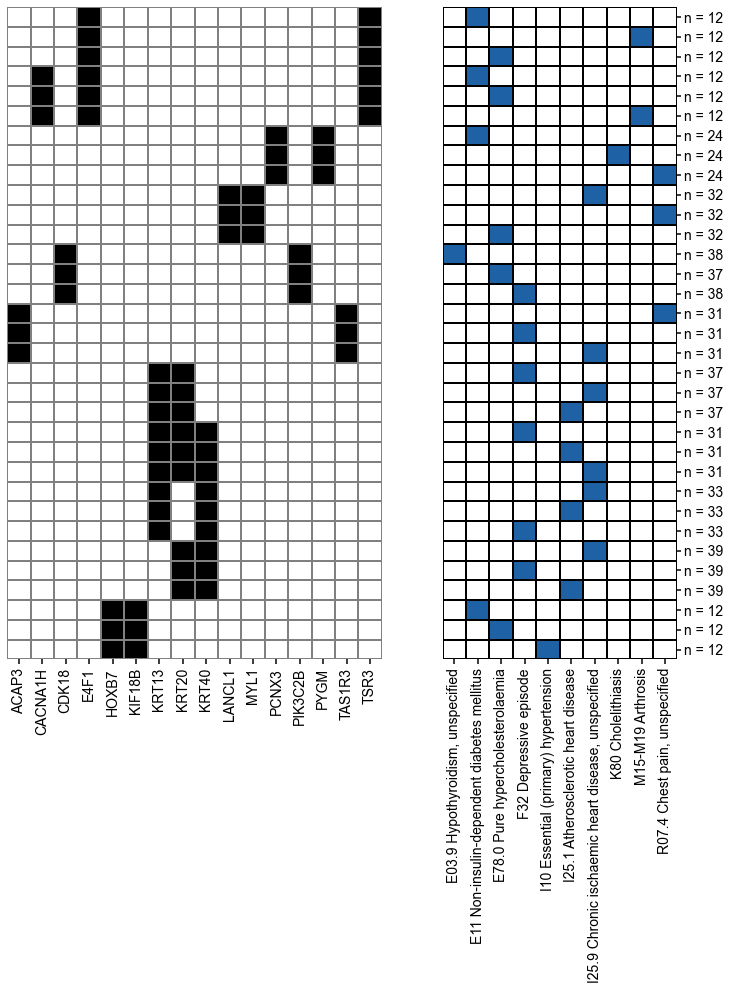

In [12]:
# fig, ax = plt.subplots(1,3, figsize=(12, 12), gridspec_kw={'width_ratios': [len(gene_cols), len(other_cols), 1]})
fig, ax = plt.subplots(1,2, figsize=(12, 12), gridspec_kw={'width_ratios': [len(gene_cols), len(other_cols)]})
g1 = sns.heatmap(
    data=combo_plot_df.loc[:, gene_cols], 
    linewidths=1.5,
    linecolor="grey", 
    cbar=False,
    cmap=["w", "k"], # "w", "#ab162a" 
    ax=ax[0],
    yticklabels=False,
    square=False,
    )
g2 = sns.heatmap(
    data=combo_plot_df.loc[:, other_cols], 
    linewidths=1.5,
    linecolor="k", 
    cbar=False,
    cmap=["w", "#1e61a5"], # "w", "#ab162a"
    ax=ax[1],
    yticklabels=False,
    square=False,
    )

# g3 = sns.heatmap(
#     data=(combo_plot_df.loc[:, "Obesity_risk"]>0).to_frame(), 
#     linewidths=1.5,
#     linecolor="w", 
#     cbar=False,
#     cmap=["#ab162a"], # "#ab162a"
#     ax=ax[2],
#     # annot=combo_plot_df.loc[:, "Obesity_risk"].to_frame(),
#     yticklabels=False,
#     square=False,
#     )

ax[0].set_ylabel("")
ax[1].set_ylabel("")
# ax[2].set_ylabel("")
# ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=90)
ax[1].yaxis.tick_right()
ax[1].set_yticks(np.arange(len(combo_plot_df)) + 0.5, combo_plot_df.loc[:, "Obesity_risk"].map(lambda x: f"n = {x}"), rotation=0);

In [13]:
save_file = "/data5/deepro/ukbiobank/papers/bmi_project/4_characterization/obesity_related_diseases/data/profile/icd_profile.pdf"
save_pdf(save_file, fig)